### Job description screening by NLP
Chiyuan Cheng
- load job description in google sheet and find the matching keywords by NLP
- A small project for information extraction


In [0]:
#importing all required libraries
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
#import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO

import spacy #use NLP functions
from spacy import displacy
import en_core_web_sm # pre-train model
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher
import nltk #NLP data processing library (IMDB)
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases # phraser optimizes phrases

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
from gensim.models.phrases import Phraser, Phrases # phraser optimizes phrases
from keras.preprocessing.text import one_hot # relation
from textblob import TextBlob

from sklearn.manifold import TSNE
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

from keras.preprocessing.text import one_hot # relation
from collections import Counter

#### Load data

In [0]:
# load data from google sheet
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1_7xr5Wfe1Zxz31fRAg4HxM7579p7pLyv2DQeynqAeNQ/edit?folder=1Zdk9qp8mD6x93sdLr14SMf-iczSrlrsP#gid=0')

In [0]:
def load_googlesheet(sheetname):
  '''
  input sheetname
  output pd.dataframe
  '''
  sheet = wb.worksheet(sheetname) # sheet name
  data = sheet.get_all_values() # load sheet
  df = pd.DataFrame(data)
  df.columns = df.iloc[0]
  df = df.iloc[1:]
  df=df.reset_index(drop=True)
  return df

In [0]:
# data for job discription
df_jd = load_googlesheet('Sheet1')
# data for keywords
df_kw = load_googlesheet('keywords')

In [87]:
display(df_jd.head(3))
display(df_kw.head(3))

,Financial,Healthcare,e-com,social media,consumer,Information
0,"Two Sigma, The Alpha Insights team at Two Sigm...","Novo Nordisk, The Clinical, Medical and Regula...",Walmart Position Description\n\nA Staff Data S...,"Facebook, We’re looking for Data Scientists to...","Uniliever, Background & Purpose of the Job\n\n...","Google, Note: By applying to this position you..."
1,"Prudential Financial,\n\nAs we create a divers...","Aetna, Description:\r\nIt’s a new day in healt...","Walmart, As a part of Walmart’s Customer Data ...","Facebook, With over 2.1 billion people, our co...",,
2,Machine Learning Research Scientist - Pattern ...,"Blink Health, Blink Health ( https://www.blink...","Amazon, Description\r\n\r\nAre you seeking an ...","New York Times, The New York Times is a techno...",,


,statistics,machine learning,deep learning,python langugage,R language,nlp,data engineering,visualization,soft skills
0,statistical models,linear regression,neural network,flask,R,natural language processing,aws,matplotlib,Communication
1,statistical modeling,logestic regression,keras,pandas,ggplot,topic modeling,ecs,seaborn,experience
2,probability,k means,theano,numpy,shiny,lda,amazon redshift,visualization,outside the box


#### Text Preprocessing

In [0]:
df_clean = df_jd.copy()

In [0]:
# remove punctuations and lowercase
result_punctuation = string.punctuation + str('\n') + str('\r')
for names in df_clean.columns:
  for i in range(df_clean[names].shape[0]):
    for char in df_clean[names][i]:
      if char in result_punctuation:
        df_clean[names][i] = df_clean[names][i].replace(char, " ").lower()#

In [125]:
df_clean.head()

,Financial,Healthcare,e-com,social media,consumer,Information
0,two sigma the alpha insights team at two sigm...,novo nordisk the clinical medical and regula...,walmart position description a staff data sci...,facebook we’re looking for data scientists to...,uniliever background purpose of the job as...,google note by applying to this position you...
1,prudential financial as we create a diverse ...,aetna description it’s a new day in health ...,walmart as a part of walmart’s customer data ...,facebook with over 2 1 billion people our co...,,
2,machine learning research scientist pattern ...,blink health blink health https www blink...,amazon description are you seeking an envi...,new york times the new york times is a techno...,,
3,venmo about us venmo was founded on the prin...,oscar hi we re oscar we re hiring a data sc...,amazon description amazon is looking for a...,wolters kluwer data scientist – r0006015 wol...,,
4,sofi who we are sofi is a digital personal f...,oscar hi we re oscar we re hiring a data sc...,amazon where will amazon s growth come from i...,bloomberg news and social media move financia...,,


In [140]:
df_clean.head()

,Financial,Healthcare,e-com,social media,consumer,Information
0,two sigma the alpha insights team at two sigm...,novo nordisk the clinical medical and regula...,walmart position description a staff data sci...,facebook we’re looking for data scientists to...,uniliever background purpose of the job as...,google note by applying to this position you...
1,prudential financial as we create a diverse ...,aetna description it’s a new day in health ...,walmart as a part of walmart’s customer data ...,facebook with over 2 1 billion people our co...,,
2,machine learning research scientist pattern ...,blink health blink health https www blink...,amazon description are you seeking an envi...,new york times the new york times is a techno...,,
3,venmo about us venmo was founded on the prin...,oscar hi we re oscar we re hiring a data sc...,amazon description amazon is looking for a...,wolters kluwer data scientist – r0006015 wol...,,
4,sofi who we are sofi is a digital personal f...,oscar hi we re oscar we re hiring a data sc...,amazon where will amazon s growth come from i...,bloomberg news and social media move financia...,,


stop words

In [190]:
# print stop words from spacy
nlp = en_core_web_sm.load()  # spacy language model
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation) 
stop_words.append('two')
print(stop_words)
print('numbers of stopwords =',len(stop_words))

['’ll', 'ca', 'out', 'into', 'seems', 'doing', 'it', 'beforehand', 'down', 'from', 'three', 'neither', "'m", 'made', 'former', 'elsewhere', 'if', 'take', '’ve', 'put', 'seemed', 'forty', 'eight', 'whereafter', 'perhaps', 'at', '‘s', 'say', 'each', 'always', 'as', 'was', '’re', 'about', 'him', 'back', 'just', 'really', 'myself', 'sometime', 'twelve', 'wherein', 'well', 'with', 'once', 'there', 'seeming', '‘re', 'hereafter', 'bottom', 'third', 'nor', 'might', 'why', 'five', "'ll", 'call', 'give', 'in', 'have', 'do', 'where', "n't", 'please', 'their', 'among', 'some', 'yourself', 'should', 'almost', 'below', 'over', 'whereupon', 'therefore', 'were', 'would', 'you', 'else', 'every', 'become', 'serious', 'alone', 'twenty', 'them', 'thereafter', 'often', 'whither', "'s", 'but', 'hundred', 'an', "'d", 'one', 'side', 'herself', 'being', 'on', 'when', 'she', 'around', '‘ve', 'much', 'whatever', 'since', 'whenever', 'because', 'although', 'same', 'thereby', 'nobody', 'done', 'mine', 'so', 'those

In [0]:
# Function to remove the stopwords
def stwds(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])
# Applying the stopwords to 'text_punct' and store into 'text_stop'
#df_clean["Financial_stop"] = 
#df_clean["Financial"].apply(stwds)
#df_clean["Financial_stop"].head()


In [202]:
#[w for w in df_clean.iloc[:,0] if w =='two']
#df_clean.iloc[:,5].apply(stwds)
for w in df_clean.iloc[:,0].str.split():
  #if w in stop_words:
    print('---')
    print(w)

---
['two', 'sigma', 'the', 'alpha', 'insights', 'team', 'at', 'two', 'sigma', 'is', 'looking', 'for', 'an', 'entrepreneurial', 'data', 'scientist', 'to', 'contribute', 'to', 'its', 'data', 'driven', 'investment', 'initiatives', 'alpha', 'insights', 'crowdsources', 'the', 'world’s', 'investment', 'insights', 'and', 'through', 'such', 'data', 'creation', 'we', 'are', 'an', 'integral', 'part', 'of', 'two', 'sigma', 'investment', 'management', 'process', 'we', 'interact', 'with', 'people', 'external', 'to', 'the', 'firm', 'to', 'collect', 'and', 'analyze', 'their', 'investment', 'insights', 'through', 'our', 'web', 'and', 'mobile', 'products', 'data', 'science', 'in', 'alpha', 'insights', 'has', '3', 'missions', '1', 'make', 'relevant', 'data', 'and', 'metrics', 'accessible', 'to', 'the', 'team', '2', 'perform', 'analyses', 'to', 'guide', 'business', 'and', 'product', 'decisions', 'and', '3', 'build', 'data', 'driven', 'features', 'that', 'power', 'our', 'products', 'you', 'will', 'take',

In [192]:
stop_words

['’ll',
 'ca',
 'out',
 'into',
 'seems',
 'doing',
 'it',
 'beforehand',
 'down',
 'from',
 'three',
 'neither',
 "'m",
 'made',
 'former',
 'elsewhere',
 'if',
 'take',
 '’ve',
 'put',
 'seemed',
 'forty',
 'eight',
 'whereafter',
 'perhaps',
 'at',
 '‘s',
 'say',
 'each',
 'always',
 'as',
 'was',
 '’re',
 'about',
 'him',
 'back',
 'just',
 'really',
 'myself',
 'sometime',
 'twelve',
 'wherein',
 'well',
 'with',
 'once',
 'there',
 'seeming',
 '‘re',
 'hereafter',
 'bottom',
 'third',
 'nor',
 'might',
 'why',
 'five',
 "'ll",
 'call',
 'give',
 'in',
 'have',
 'do',
 'where',
 "n't",
 'please',
 'their',
 'among',
 'some',
 'yourself',
 'should',
 'almost',
 'below',
 'over',
 'whereupon',
 'therefore',
 'were',
 'would',
 'you',
 'else',
 'every',
 'become',
 'serious',
 'alone',
 'twenty',
 'them',
 'thereafter',
 'often',
 'whither',
 "'s",
 'but',
 'hundred',
 'an',
 "'d",
 'one',
 'side',
 'herself',
 'being',
 'on',
 'when',
 'she',
 'around',
 '‘ve',
 'much',
 'whatever',

In [136]:
# word split
for names in df_jd.columns:
  for i in range(len(df_jd[names])):

    df_clean[names][i] = df_jd[names][i].split(' ')
    #df_clean[names][i] = pd.DataFrame(re.split(' |, |\n',df_jd[names][i]))
#[x.strip() for x in my_string.split(',')]

df_clean.head()

,Financial,Healthcare,e-com,social media,consumer,Information
0,"[Two, Sigma,, The, Alpha, Insights, team, at, ...","[Novo, Nordisk,, The, Clinical,, Medical, and,...","[Walmart, Position, Description\n\nA, Staff, D...","[Facebook,, We’re, looking, for, Data, Scienti...","[Uniliever,, Background, &, Purpose, of, the, ...","[Google,, Note:, By, applying, to, this, posit..."
1,"[Prudential, Financial,\n\nAs, we, create, a, ...","[Aetna,, Description:\r\nIt’s, a, new, day, in...","[Walmart,, As, a, part, of, Walmart’s, Custome...","[Facebook,, With, over, 2.1, billion, people,,...",[],[]
2,"[Machine, Learning, Research, Scientist, -, Pa...","[Blink, Health,, Blink, Health, (, https://www...","[Amazon,, Description\r\n\r\nAre, you, seeking...","[New, York, Times,, The, New, York, Times, is,...",[],[]
3,"[Venmo,, About, Us\n\nVenmo, was, founded, on,...","[Oscar,, Hi,, we're, Oscar., We're, hiring, a,...","[Amazon,, Description\r\n\r\nAmazon, is, looki...","[Wolters, Kluwer,, Data, Scientist, –, R000601...",[],[]
4,"[Sofi,, Who, We, Are\n\nSoFi, is, a, digital, ...","[Oscar,, Hi,, we're, Oscar., We're, hiring, a,...","[Amazon,, Where, will, Amazon's, growth, come,...","[Bloomberg,, News, and, social, media, move, f...",[],[]


In [92]:
df_clean.head()

,Financial,Healthcare,e-com,social media,consumer,Information
0,two sigma the alpha insights team at two sigm...,novo nordisk the clinical medical and regula...,walmart position description a staff data sci...,facebook we’re looking for data scientists to...,uniliever background purpose of the job as...,google note by applying to this position you...
1,prudential financial as we create a diverse ...,aetna description it’s a new day in health ...,walmart as a part of walmart’s customer data ...,facebook with over 2 1 billion people our co...,,
2,machine learning research scientist pattern ...,blink health blink health https www blink...,amazon description are you seeking an envi...,new york times the new york times is a techno...,,
3,venmo about us venmo was founded on the prin...,oscar hi we re oscar we re hiring a data sc...,amazon description amazon is looking for a...,wolters kluwer data scientist – r0006015 wol...,,
4,sofi who we are sofi is a digital personal f...,oscar hi we re oscar we re hiring a data sc...,amazon where will amazon s growth come from i...,bloomberg news and social media move financia...,,


In [0]:
def word_clean(df, columns):
  '''
  input: dataset and column name
  output: lowercase word without stop words
  '''
  df_clean = []
  for discription in df[columns]:
    #lower_words = []
    for word in discription:
      if not word.lower() in stopwords:
        #lower_words.append(word.lower())
        df_clean.append(word.lower())
    #df_clean.append(lower_words)
  return df_clean


In [135]:
text_financial = word_clean(df_clean, 'Financial')

AttributeError: ignored

In [0]:
#word_clean(df1, 'Financial');
# check stop words
w = ['(1)', '(2)','(3)','&', 'r,)','(e.g.','e.g.','etc.).','ms','3-5','3','r,','3+','â©','2+']
stopwords1 = list(stopwords)+(w)
#for i in w:
#  nlp.vocab[i].is_stop = True
#nlp.vocab['christchurch'].is_stop = True
#nlp.vocab['new zealand'].is_stop = True


#### keywords

In [0]:
test=pd.Series(text_financial)#.values.replace('\\n','')
test.replace('\\n', '', inplace=True)

In [43]:
df_kw.columns

Index(['statistics', 'machine learning', 'deep learning', 'python langugage',
       'R language', 'nlp', 'data engineering', 'visualization',
       'soft skills'],
      dtype='object', name=0)

In [0]:
words_stats = [nlp(text) for text in df_kw['statistics'].dropna(axis=0)]
words_ml = [nlp(text) for text in df_kw['machine learning'].dropna(axis=0)]
words_dl = [nlp(text) for text in df_kw['deep learning'].dropna(axis=0)]
words_py = [nlp(text) for text in df_kw['python langugage'].dropna(axis=0)]
words_r = [nlp(text) for text in df_kw['R language'].dropna(axis=0)]
words_nlp = [nlp(text) for text in df_kw['nlp'].dropna(axis=0)]
words_de = [nlp(text) for text in df_kw['data engineering'].dropna(axis=0)]
words_vis = [nlp(text) for text in df_kw['visualization'].dropna(axis=0)]
words_ss = [nlp(text) for text in df_kw['soft skills'].dropna(axis=0)]

In [0]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('D:/NLP_Resume/resume/template_new.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)

#### Topic Modeling with LSA

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from collections import Counter

In [0]:
reindexed_data = np.array(word_clean(df_clean, 'Healthcare'))
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data#.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [0]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [0]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [0]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [0]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [0]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  data driven addition
Topic 2:  experience datasets text
Topic 3:  analytics oscar analysis
Topic 4:  health models care
Topic 5:  work product business
Topic 6:  new team projects


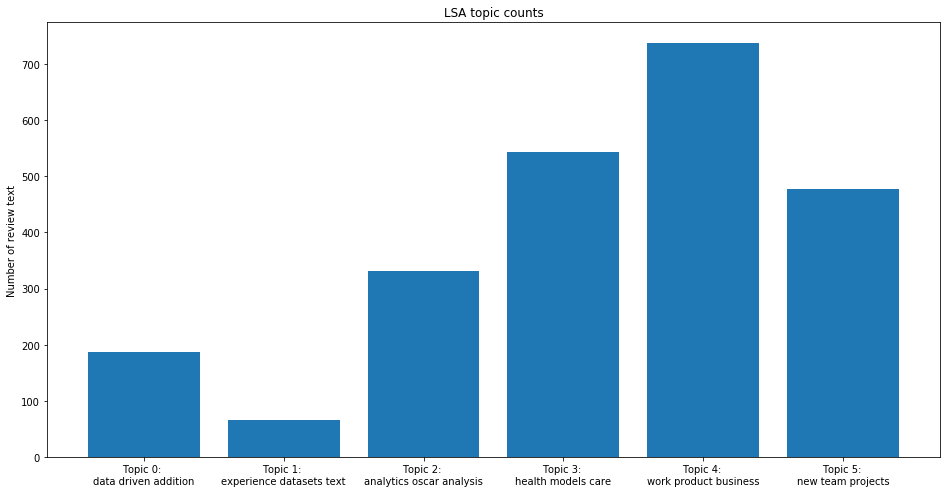

In [0]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

In [0]:
df_hc = pd.DataFrame(word_clean(df_clean, 'Healthcare'), columns=['names'])

In [0]:
df_hc.head()

,names
0,novo
1,"nordisk,"
2,"clinical,"
3,medical
4,regulatory


In [0]:
df_hc['names'].value_counts().nlargest(20)

data           66
experience     35
analytics      26
work           26
new            25
health         25
product        19
team           18
statistical    15
business       15
strong         11
healthcare     11
years          11
develop        10
care           10
models         10
development    10
people         10
analysis        9
-               9
Name: names, dtype: int64